In [64]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

In [65]:
os.makedirs("./plots", exist_ok=True)
os.makedirs("./results", exist_ok=True)

os.chdir('/Users/jaysenkang/deep-learning-pricer')

In [66]:
df = pd.read_csv("./data/generated_asian_option_data.csv")
X = df[["S0", "r", "T", "K", "sigma"]].values
y = df["price"].values.reshape(-1, 1)

feature_scaler = StandardScaler()
label_scaler = StandardScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = label_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

device = "cuda" if torch.cuda.is_available() else "cpu"

X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_t = torch.tensor(y_test, dtype=torch.float32, device=device)

In [67]:
class AsianOptionNN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

In [68]:
state_dict = torch.load("./models/asian_option_pricer.pt")
hidden_dim = state_dict['net.0.weight'].shape[0]

model = AsianOptionNN(input_dim=5, hidden_dim=hidden_dim).to(device)
model.load_state_dict(state_dict)
model.eval()

/var/folders/tc/84_mcl9j78jd5jc7sqtwg77m0000gn/T/ipykernel_76340/1704561650.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./models/asian_optio

AsianOptionNN(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [69]:
with torch.no_grad():
    y_pred_scaled = model(X_test_t).cpu().numpy()

y_pred = label_scaler.inverse_transform(y_pred_scaled)
y_true = label_scaler.inverse_transform(y_test_t.cpu().numpy())

errors = y_pred.flatten() - y_true.flatten()
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(errors))

print(f"\nTest MSE (original scale): {mse:.6f}")
print(f"Test RMSE (original scale): {rmse:.6f}")
print(f"Test MAE (original scale): {mae:.6f}")


Test MSE (original scale): 0.026089
Test RMSE (original scale): 0.161520
Test MAE (original scale): 0.131204


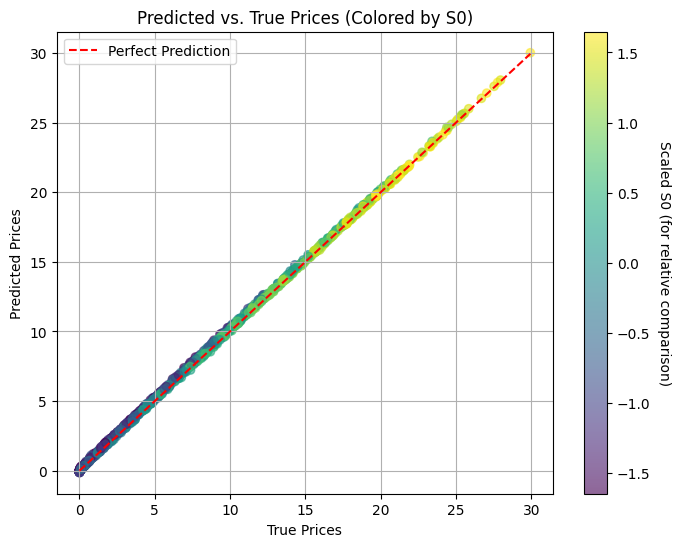

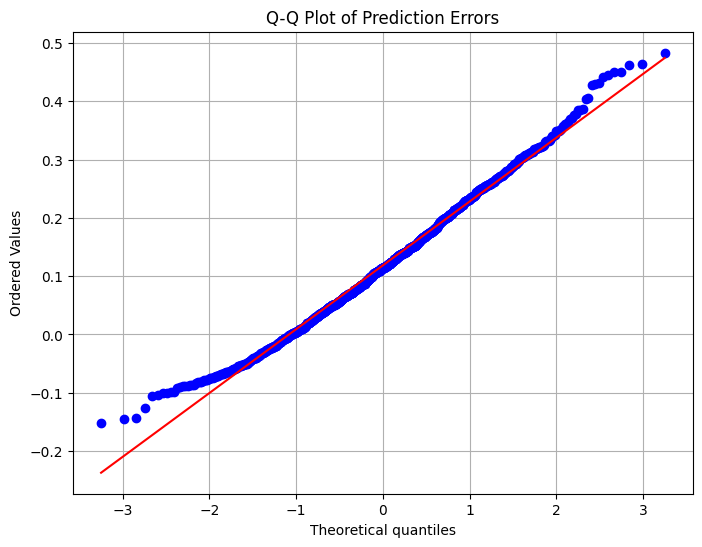

In [70]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_true, y_pred, c=X_test[:, 0], cmap='viridis', alpha=0.6) 

plt.plot(
    [min(y_true), max(y_true)],
    [min(y_true), max(y_true)],
    color='red', linestyle='--', label='Perfect Prediction'
)
cbar = plt.colorbar(sc)
cbar.set_label('Scaled S0 (for relative comparison)', rotation=270, labelpad=15)
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs. True Prices (Colored by S0)")
plt.legend()
plt.grid()
plt.savefig("./plots/predicted_vs_true_colored_by_S0.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q-Q Plot of Prediction Errors")
plt.grid()
plt.savefig("./plots/residual_qq_plot.png", dpi=300, bbox_inches='tight')
plt.show()


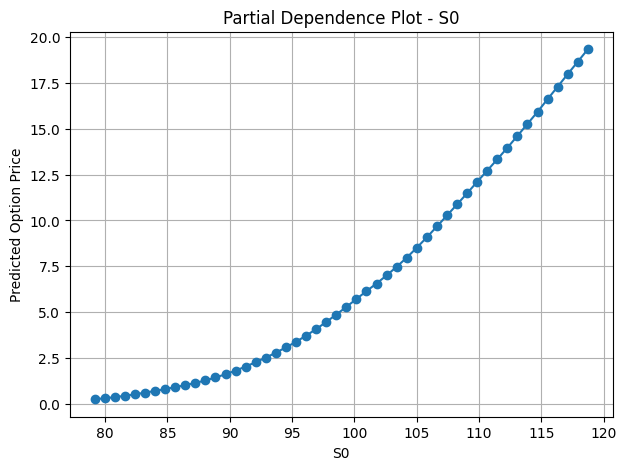

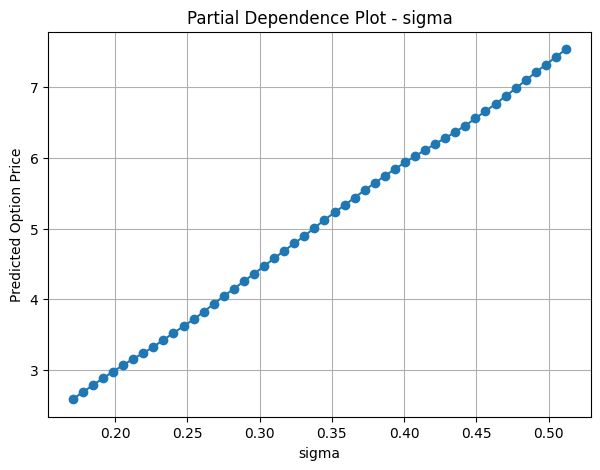

In [71]:
def partial_dependence(model, feature_scaler, label_scaler, base_values, feature_index, feature_name, 
                       lower_bound, upper_bound, num_points=50):
    """
    model: the trained neural network
    feature_scaler: scaler for the features
    label_scaler: scaler for the label
    base_values: the 'typical' or base input vector in original scale
    feature_index: which feature to vary
    feature_name: name of the feature to display on the plot
    lower_bound, upper_bound: range in original scale for that feature
    num_points: how many points to sample in the range
    """
    
    values_to_try = np.linspace(lower_bound, upper_bound, num_points)
    
    predictions = []
    for val in values_to_try:
        x_mod = base_values.copy()
        x_mod[feature_index] = val

        x_mod_scaled = feature_scaler.transform([x_mod])  
        x_mod_scaled_tensor = torch.tensor(x_mod_scaled, dtype=torch.float32, device=device)
        with torch.no_grad():
            y_mod_pred_scaled = model(x_mod_scaled_tensor).cpu().numpy()

        y_mod_pred = label_scaler.inverse_transform(y_mod_pred_scaled)
        predictions.append(y_mod_pred.flatten()[0])
    
    plt.figure(figsize=(7,5))
    plt.plot(values_to_try, predictions, marker='o')
    plt.xlabel(feature_name)
    plt.ylabel("Predicted Option Price")
    plt.title(f"Partial Dependence Plot - {feature_name}")
    plt.grid()
    plt.savefig(f"./plots/pdp_{feature_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

X_test_original = feature_scaler.inverse_transform(X_test)
base_values = np.median(X_test_original, axis=0)  

median_S0 = base_values[0]
pdp_lower_S0 = 0.8 * median_S0
pdp_upper_S0 = 1.2 * median_S0

partial_dependence(
    model, feature_scaler, label_scaler, base_values,
    feature_index=0,  
    feature_name='S0',
    lower_bound=pdp_lower_S0,
    upper_bound=pdp_upper_S0,
    num_points=50
)

median_sigma = base_values[4]
pdp_lower_sigma = 0.5 * median_sigma
pdp_upper_sigma = 1.5 * median_sigma

partial_dependence(
    model, feature_scaler, label_scaler, base_values,
    feature_index=4,  
    feature_name='sigma',
    lower_bound=pdp_lower_sigma,
    upper_bound=pdp_upper_sigma,
    num_points=50
)

In [72]:
report_df = pd.DataFrame({
    "True Price": y_true.flatten(),
    "Predicted Price": y_pred.flatten(),
    "Error": errors.flatten()
})
report_df.to_csv("./results/evaluation_report.csv", index=False)
print("Evaluation report saved to ./results/evaluation_report.csv")


Evaluation report saved to ./results/evaluation_report.csv
